In [26]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import skimage
import pylops

(50, 50)

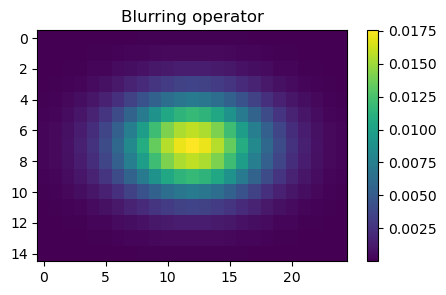

In [16]:
#import image
imG = skimage.data.chelsea()[0:50, 0:50, 0]
imB = skimage.data.chelsea()[0:50, 0:50, 1]
imR = skimage.data.chelsea()[0:50, 0:50, 2]

N = 3
Nz, Nx = imG.shape

# Blurring guassian operator
nh = [15, 25]
hz = np.exp(-0.1 * np.linspace(-(nh[0] // 2), nh[0] // 2, nh[0]) ** 2)
hx = np.exp(-0.03 * np.linspace(-(nh[1] // 2), nh[1] // 2, nh[1]) ** 2)
hz /= np.trapz(hz)  # normalize the integral to 1
hx /= np.trapz(hx)  # normalize the integral to 1
h = hz[:, np.newaxis] * hx[np.newaxis, :]

#picture of blurring operator
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h)
ax.set_title("Blurring operator")
fig.colorbar(him, ax=ax)
ax.axis("tight")

#Blurring operator
Cop = pylops.signalprocessing.Convolve2D(
    (Nz, Nx), h=h, offset=(nh[0] // 2, nh[1] // 2), dtype="float32"
)

#Single TV regularizer
Dop = [
    pylops.FirstDerivative((Nz, Nx), axis=0, edge=False),
    pylops.FirstDerivative((Nz, Nx), axis=1, edge=False),
]

#auxillary operator
Wop = pylops.signalprocessing.DWT2D((Nz, Nx), wavelet="haar", level=3)

In [17]:
#Joint TV regularizer
def JDop(N):
    Ops = []
    for i in range(N):
        Ops.append(pylops.FirstDerivative((Nz, Nx), axis=0, edge=False))
    Ops1 = []
    for i in range(N):
        Ops1.append(pylops.FirstDerivative((Nz, Nx), axis=1, edge=False))
    return [pylops.BlockDiag(Ops, nproc=1), pylops.BlockDiag(Ops1, nproc=1)]

#Joint blurring operator
def JCop(N):
    Ops = []
    for i in range(N):
        Ops.append(pylops.signalprocessing.Convolve2D((Nz, Nx), h=h, offset=(nh[0] // 2, nh[1] // 2), dtype="float32"))
    return pylops.BlockDiag(Ops, nproc=1)

type(Dop), type(JDop(3))

(list, list)

In [18]:
#solving methods
#solving the normal equations
def normal_inv(imblur):
    imdeblur = pylops.optimization.leastsquares.normal_equations_inversion(
        Cop, imblur.ravel(), None, maxiter=5  # solvers need 1D arrays
    )[0]
    imdeblur = imdeblur.reshape(Cop.dims)
    return imdeblur

def Jnormal_inv(imblur, N):
    imdeblur = pylops.optimization.leastsquares.normal_equations_inversion(
        JCop(N), imblur.ravel(), None, maxiter=5  # solvers need 1D arrays
    )[0]
    imdeblur = imdeblur.reshape(JCop(N).dims)
    return imdeblur

#Fast Iterative Shrinkage-Thresholding Algorithm
def fista(imblur):
    imdeblurfista = pylops.optimization.sparsity.fista(
        Cop * Wop.H, imblur.ravel(), eps=1e-1, niter=100
    )[0]
    imdeblurfista = imdeblurfista.reshape((Cop * Wop.H).dims)
    imdeblurfista = Wop.H * imdeblurfista
    return imdeblurfista

#Deblurring with TV
def TV_inv(imblur):
    imdeblurtv = pylops.optimization.sparsity.splitbregman(
        Cop,
        imblur.ravel(),
        Dop,
        niter_outer=10,
        niter_inner=5,
        mu=1.5,
        epsRL1s=[2e0, 2e0],
        tol=1e-4,
        tau=1.0,
        show=False,
        **dict(iter_lim=5, damp=1e-4)
    )[0]
    imdeblurtv = imdeblurtv.reshape(Cop.dims)
    return imdeblurtv

def JTV_inv(imblur, N):
    _JCop = JCop(N)
    _JDop = JDop(N)
    imdeblurtv = pylops.optimization.sparsity.splitbregman(
        _JCop,
        imblur.ravel(),
        _JDop,
        niter_outer=10,
        niter_inner=5,
        mu=1.5,
        epsRL1s=[2e0, 2e0, 2e0, 2e0, 2e0, 2e0],
        tol=1e-4,
        tau=1.0,
        show=False,
        **dict(iter_lim=5, damp=1e-4)
    )[0]
    imdeblurtv = imdeblurtv.reshape(_JCop.dims)
    return imdeblurtv

In [137]:
def integrand(xi):
    val = (xi[0][0] * xi[1][1])**2 + (xi[0][0] * xi[2][1])**2 + (xi[1][0] * xi[0][1])**2 + (xi[1][0] * xi[2][1])**2 + (xi[2][0] * xi[0][1])**2 + (xi[2][0] * xi[1][1])**2 - 2 *(xi[0][0] * xi[0][1] * xi[1][0] * xi[1][1] + xi[0][0] * xi[0][1] * xi[2][0] * xi[2][1] + xi[1][0] * xi[1][1] * xi[2][0] * xi[2][1])
    return val

def J(u_0, u_1, u_2):
    xi = np.array([[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_0), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_0)],[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_1), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_1)],[pylops.FirstDerivative((Nz, Nx), axis=0, edge=False)._matvec(u_2), pylops.FirstDerivative((Nz, Nx), axis=1, edge=False)._matvec(u_2)]])
    return integrand(xi).sum()

-7.676198818324588e-11

In [285]:
#solving the joint regularizer
def joint_TV_J(fun, x0, jac):
    return sp.optimize.minimize(fun, x0, method='L-BFGS-B', jac=None, bounds=[[0, 255], [0, 255]], options = {'maxiter' : 50})

def f_switch(u):
    return f_CG(u[:Nz * Nx], u[Nz * Nx: 2 * Nz * Nx], u[2 * Nz * Nx:])

def f_CG(u_0, u_1, u_2):
    a = 1
    b = 1
    return ((Cop* u_0 - Jimblur[0].ravel())**2).sum() + ((Cop*u_1 - Jimblur[1].ravel())**2).sum() + ((Cop*u_2 - Jimblur[2].ravel())**2).sum() + a * np.array([np.abs(Dop[0] * u_0), np.abs(Dop[1] * u_0), np.abs(Dop[0] * u_1), np.abs(Dop[1] * u_1), np.abs(Dop[0] * u_2), np.abs(Dop[1] * u_2) ]).sum() + b * J(u_0, u_1, u_2)

result = sp.optimize.minimize(f_switch, x0 = np.array([Jimblur[0], Jimblur[1], Jimblur[2]]).ravel(),  options = {'maxiter' : 100})
print(result)

  message: Maximum number of iterations has been exceeded.
  success: False
   status: 1
      fun: 88689.04386748461
        x: [ 7.646e+01  9.618e+01 ...  3.436e+01  2.608e+01]
      nit: 100
      jac: [-3.488e+00 -2.927e+01 ... -7.754e-01 -1.233e+00]
 hess_inv: [[ 1.010e+00  9.059e-03 ...  1.746e-03  3.581e-03]
            [ 9.059e-03  9.472e-01 ...  4.957e-04  3.122e-03]
            ...
            [ 1.746e-03  4.957e-04 ...  9.774e-01  5.983e-04]
            [ 3.581e-03  3.122e-03 ...  5.983e-04  1.001e+00]]
     nfev: 765102
     njev: 102


In [19]:
#error measure
def calculate_psnr(original, compressed, max_pixel=255):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_mse(reference, candidate):
    assert len(reference) == len(candidate)
    return (np.square(reference - candidate)).mean(axis=None)

def plot_mse(reference, candidates):
    for candidate in candidates:
        mse_values = []
        for i in range(reference.shape[0]):
            mse = calculate_mse(reference[i,::], candidate[i,::])
            mse_values.append(mse)

        plt.plot(mse_values)

    plt.xlabel('RGB')
    plt.ylabel('MSE')
    plt.title('Mean Squared Error (MSE) Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

In [80]:
imblurG = Cop * imG
imblurB = Cop * imB
imblurR = Cop * imR

Jim = np.array([imG, imB, imR])
Jimblur = np.array([imblurG, imblurB, imblurR])

#xi = np.array([0, imblurG[], ], [,],[,])

array([0., 0., 0., ..., 0., 0., 0.])

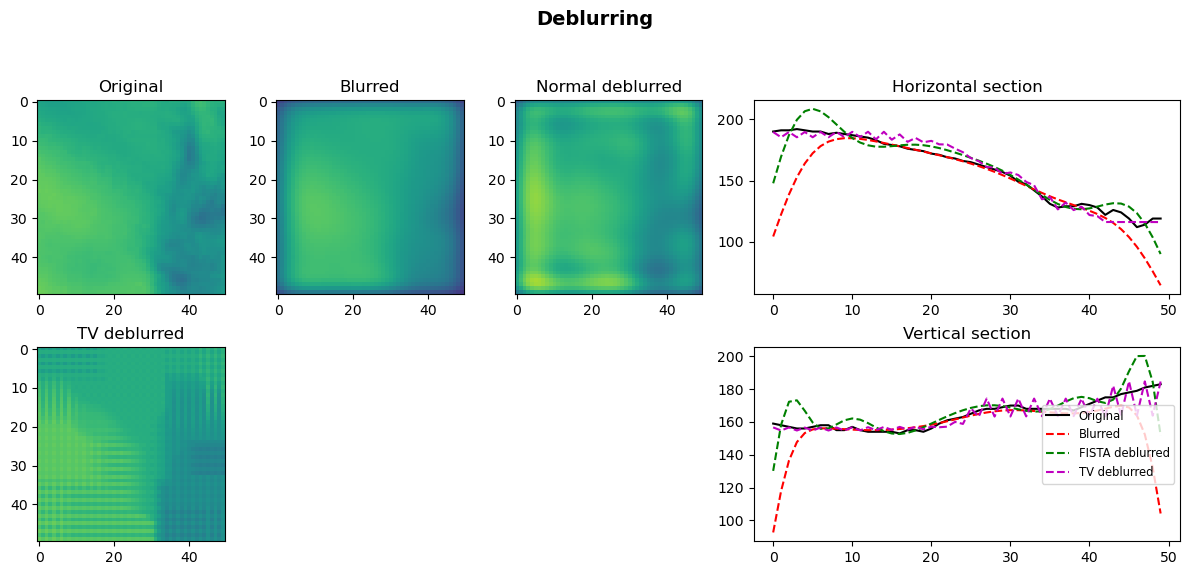

In [23]:
def plot_result(image, imblur, imdeblurfista, imdeblurtv):
    #image.shape must have length 2
    Nz, Nx = image.shape
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle("Deblurring", fontsize=14, fontweight="bold", y=0.95)
    ax1 = plt.subplot2grid((2, 5), (0, 0))
    ax2 = plt.subplot2grid((2, 5), (0, 1))
    ax3 = plt.subplot2grid((2, 5), (0, 2))
    ax4 = plt.subplot2grid((2, 5), (1, 0))
    ax5 = plt.subplot2grid((2, 5), (0, 3), colspan=2)
    ax6 = plt.subplot2grid((2, 5), (1, 3), colspan=2)
    ax1.imshow(image, cmap="viridis", vmin=0, vmax=250)
    ax1.axis("tight")
    ax1.set_title("Original")
    ax2.imshow(imblur, cmap="viridis", vmin=0, vmax=250)
    ax2.axis("tight")
    ax2.set_title("Blurred")
    ax3.imshow(imdeblurfista, cmap="viridis", vmin=0, vmax=250)
    ax3.axis("tight")
    ax3.set_title("Normal deblurred")
    ax4.imshow(imdeblurtv, cmap="viridis", vmin=0, vmax=250)
    ax4.axis("tight")
    ax4.set_title("TV deblurred")
    ax5.plot(image[Nz // 2], "k")
    ax5.plot(imblur[Nz // 2], "--r")
    ax5.plot(imdeblurfista[Nz // 2], "--g")
    ax5.plot(imdeblurtv[Nz // 2], "--m")
    ax5.axis("tight")
    ax5.set_title("Horizontal section")
    ax6.plot(image[:, Nx // 2], "k", label="Original")
    ax6.plot(imblur[:, Nx // 2], "--r", label="Blurred")
    ax6.plot(imdeblurfista[:, Nx // 2], "--g", label="FISTA deblurred")
    ax6.plot(imdeblurtv[:, Nx // 2], "--m", label="TV deblurred")
    ax6.axis("tight")
    ax6.set_title("Vertical section")
    ax6.legend(loc=5, fontsize="small")
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    return

#plot_result(imG, imblurG, normal_inv(imblurG), fista(imblurG), TV_inv(imblurG))
#plot_result(imB, imblurB, normal_inv(imblurB), fista(imblurB), TV_inv(imblurB))
#plot_result(imR, imblurR, normal_inv(imblurR), fista(imblurR), TV_inv(imblurR))
plot_result(Jim[0], Jimblur[0], Jnormal[0], JTV[0])

In [22]:
JTV = JTV_inv(Jimblur, 3)
Jnormal = Jnormal_inv(Jimblur, 3)

In [ ]:
normal_inv, fista, TV_inv = normal_inv(imblurG),fista(imblurG), TV_inv(imblurG)

In [ ]:
# PLOT PSNR:
original_image = np.array([[100, 150], [200, 250]], dtype=np.uint8)
compressed_image = np.array([[105, 147], [198, 248]], dtype=np.uint8)

psnr_value = calculate_psnr(JTV, Jimblur)
print("PSNR:", psnr_value)

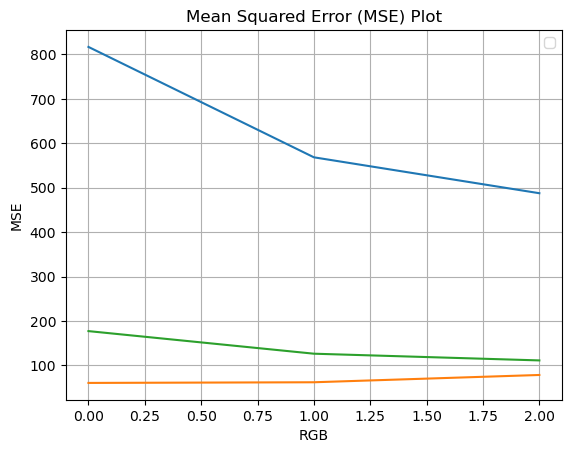

In [24]:
# Plot MSE:
reference = Jim
candidates = [Jimblur, JTV, Jnormal]
plot_mse(reference, candidates)